In [190]:
import tqdm
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

In [3]:
real_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/real_holograms_CSET_RF07_20150719_200000-210000.nc"
synthetic_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"

In [4]:
f = xr.open_dataset(synthetic_path)

In [10]:
h_idx = 2

<Figure size 700x432.624 with 0 Axes>

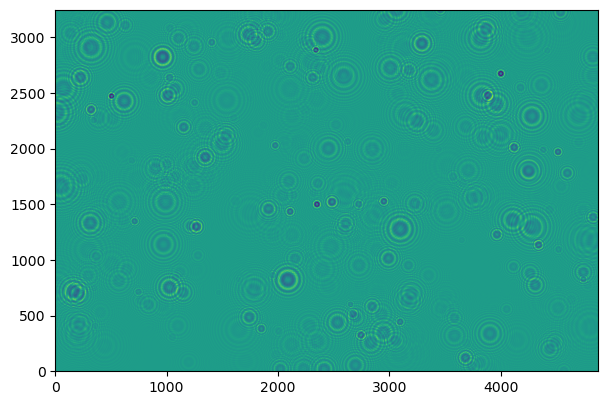

In [11]:
### Slow -- loads all data then takes the indexed example
image = f["image"].values[h_idx]

fontsize = 10
single_column_width = 7
plt.figure(figsize = (single_column_width, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})
ax.imshow(image.transpose(1,0), origin ='lower')

<Figure size 700x432.624 with 0 Axes>

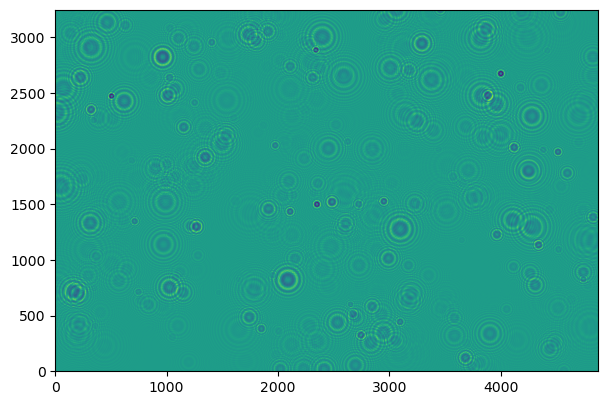

In [12]:
### Fast -- only load 1 hologram

image = f['image'].isel(hologram_number=h_idx).values

fontsize = 10
single_column_width = 7
plt.figure(figsize = (single_column_width, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})
ax.imshow(image.transpose(1,0), origin ='lower')

### Wave prop

In [13]:
class WavePropagator(object):

    def __init__(self,
                 data_path,
                 n_bins=1000,
                 tile_size=512,
                 step_size=128,
                 marker_size=10,
                 transform_mode=None,
                 device="cpu"):

        self.h_ds = xr.open_dataset(data_path)

        if 'zMin' in self.h_ds.attrs:
            self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
            self.zMax = self.h_ds.attrs['zMax']
        else:  # some of the raw data does not have this parameter
            # should warn the user here through the logger
            self.zMin = 0.014
            self.zMax = 0.158 #15.8 - 1.4 / (1000)

        self.n_bins = n_bins
        self.z_bins = np.linspace(
            self.zMin, self.zMax, n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5 * \
            np.diff(self.z_bins)  # histogram bin centers

        self.tile_size = tile_size  # size of tiled images in pixels
        self.step_size = step_size  # amount that we shift the tile to make a new tile
        # UNET gaussian marker width (standard deviation) in um
        self.marker_size = marker_size
        self.device = device

        # step_size is not allowed be be larger than the tile_size
        assert self.tile_size >= self.step_size

        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx'])  # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny'])  # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda']  # wavelength
        self.image_norm = 255.0
        self.transform_mode = transform_mode
        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy

        self.tile_x_bins = np.arange(-self.Nx//2,
                                     self.Nx//2, self.step_size)*self.dx*1e6
        self.tile_y_bins = np.arange(-self.Ny//2,
                                     self.Ny//2, self.step_size)*self.dy*1e6

        self.fx = torch.fft.fftfreq(
            self.Nx, self.dx, device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(
            self.Ny, self.dy, device=self.device).unsqueeze(0).unsqueeze(1)

    def torch_holo_set(self,
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """

        if self.transform_mode == "standard":
            Ein = Ein.float()
            Ein -= torch.mean(Ein)
            Ein /= torch.std(Ein)

        elif self.transform_mode == "min-max":
            Ein = Ein.float()
            Ein -= torch.min(Ein)
            Ein /= torch.max(Ein)

        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam *
                                torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)

        return Eout

In [14]:
def get_particle(prop, h_idx, max_coor = 0, repeat = 0):
    indices = np.where(prop.h_ds["hid"] == h_idx + 1)
    d_locations = prop.h_ds["d"].values[indices]
    x_locations = prop.h_ds["x"].values[indices]
    y_locations = prop.h_ds["y"].values[indices]
    z_locations = prop.h_ds["z"].values[indices]
    idx = np.where(d_locations == sorted(d_locations, reverse = True)[max_coor])
    xp = np.digitize(x_locations[idx][repeat], 1e6 * prop.x_arr, right=True)
    yp = np.digitize(y_locations[idx][repeat], 1e6 * prop.y_arr, right=True)
    #_zp = prop.z_centers[np.digitize(z_locations[idx][0], prop.z_centers, right=True)]
    zp = z_locations[idx][repeat]
    dp = d_locations[idx][repeat]
    #print(d_locations)
    #print(x_locations[idx], y_locations[idx], z_locations[idx], d_locations[idx])
    print(xp, yp, zp, dp)
    return xp, yp, zp, dp

In [45]:
propagator = WavePropagator(synthetic_path)

In [46]:
x, y, z, d = get_particle(propagator, h_idx)

966 2818 89001.99 81.48114


In [65]:
synth_image = f['image'].isel(hologram_number=h_idx).values

# prop
zp_im = propagator.torch_holo_set(
    torch.from_numpy(synth_image).to(device),
    torch.FloatTensor([z*1e-6]).to(device)
).squeeze(0) # this tensor is complex! 

# ABS
prop_synth = torch.abs(zp_im).cpu().numpy()
# Phase
prop_phase = torch.angle(zp_im).cpu().numpy()

<Figure size 700x432.624 with 0 Axes>

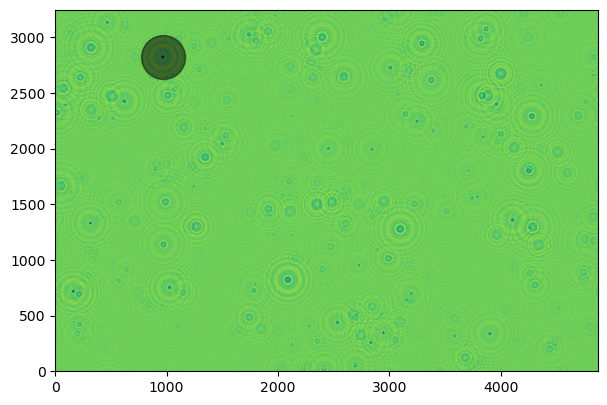

In [43]:
fontsize = 10
single_column_width = 7
plt.figure(figsize = (single_column_width, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})

ax.imshow(prop_synth.transpose(1,0), origin ='lower')
ax.scatter(x, y, c = 'k', s = 1000, alpha = 0.5)

/glade/scratch/schreck/ipykernel_198889/2883144259.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


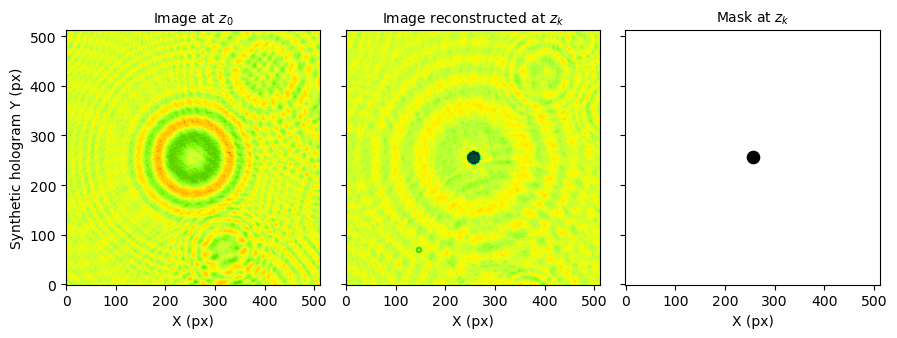

In [64]:
fontsize = 10
single_column_width = 10.5
syn_min = 0 
syn_max = 255

figsize = (single_column_width, single_column_width / 2)
fig, ax = plt.subplots(1, 3, figsize=figsize,  
                                   gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, 
                                   sharex=True, sharey=True)

synth_slice = prop_synth[(x-256):(x+256), (y-256):(y+256)]

ax[0].imshow(synth_image[(x-256):(x+256), (y-256):(y+256)].transpose((1,0)), 
             origin ='lower', vmin = syn_min, vmax = syn_max, cmap = "gist_ncar")

ax[1].imshow(synth_slice.transpose(1,0), 
             origin ='lower', vmin = syn_min, vmax = syn_max, cmap = "gist_ncar")

default = np.ones((512, 512))
ax[2].imshow(default, origin ='lower', cmap = "gray_r")

ax[2].imshow(default, origin ='lower', cmap = "gray_r")
ax[2].scatter(256, 256, c = 'k', s = 0.95 * d, alpha = 1.0)

ax[0].set_title(r"Image at $z_0$", fontsize=fontsize)
ax[1].set_title(r"Image reconstructed at $z_k$", fontsize=fontsize)
ax[2].set_title(r"Mask at $z_k$", fontsize=fontsize)

ax[0].set_ylabel(r"Synthetic hologram Y (px)", fontsize=fontsize)

ax[0].set_xlabel(r"X (px)", fontsize=fontsize)
ax[1].set_xlabel(r"X (px)", fontsize=fontsize)
ax[2].set_xlabel(r"X (px)", fontsize=fontsize)

plt.tight_layout()
#plt.savefig("figs/wave_prop_examples.pdf", bbox_inches='tight', dpi=300)

### Create a simple pytorch data loader that loads a random hologram and performs wave-prop to a random position along z.

In [310]:
def create_mask(prop, h_idx, z_idx):
    hid = h_idx + 1
    hid_mask = prop.h_ds["hid"] == hid

    # Filter particles based on h_idx
    x_part = prop.h_ds["x"].values[hid_mask]
    y_part = prop.h_ds["y"].values[hid_mask]
    z_part = prop.h_ds["z"].values[hid_mask]
    d_part = prop.h_ds["d"].values[hid_mask]

    z_indices = np.digitize(z_part, prop.z_bins) - 1
    # Initialize the UNET mask
    unet_mask = np.zeros((prop.x_arr.shape[0], prop.y_arr.shape[0]))
    num_particles = 0 
    
    if z_idx in z_indices:
        cond = np.where(z_idx == z_indices)
        x_part = x_part[cond]
        y_part = y_part[cond]
        z_part = z_part[cond]
        d_part = d_part[cond]
        
        print(x_part, y_part, z_part, d_part)
        
        # Build the UNET mask using vectorized operations
        for part_idx in range(len(cond[0])):
            y_diff = (prop.y_arr[None, :] * 1e6 - y_part[part_idx])
            x_diff = (prop.x_arr[:, None] * 1e6 - x_part[part_idx])
            d_squared = (d_part[part_idx] / 2)**2
            unet_mask += ((y_diff**2 + x_diff**2) < d_squared).astype(float)
            num_particles += 1

    return unet_mask, num_particles

In [311]:
from torch.utils.data import Dataset
import random

class FullSizeHolograms(Dataset):
    
    def __init__(self, file_path, n_bins = 1000, shuffle = False, device = "cpu"):
        
        self.n_bins = n_bins
        self.device = device
        self.shuffle = shuffle
        self.propagator = WavePropagator(file_path, n_bins = n_bins, device = device)

    def __len__(self):
        return len(self.propagator.h_ds.hologram_number) * self.n_bins

    def __getitem__(self, idx):
        
        if self.shuffle:
            idx = random.choice(range(self.__len__()))
        
        hologram_idx = idx // self.n_bins 
        plane_idx = idx // len(self.propagator.h_ds.hologram_number)
        z_prop = self.propagator.z_centers[plane_idx]
        
        # select hologram
        image = self.propagator.h_ds["image"].isel(hologram_number=hologram_idx).values
        
        # prop
        image_prop = self.propagator.torch_holo_set(
            torch.from_numpy(image).to(self.device),
            torch.FloatTensor([z_prop*1e-6]).to(self.device)
        ).squeeze(0)

        # ABS (x-input)
        prop_synth = torch.abs(image_prop).cpu().numpy()
        # Phase (x-input)
        prop_phase = torch.angle(image_prop).cpu().numpy()
        # Mask (y-label)
        mask, num_particles = create_mask(self.propagator, hologram_idx, plane_idx)
        
        print(f"Hologram # {hologram_idx}, z-plane # {plane_idx}, # particles: {num_particles}")
        
        return prop_synth, prop_phase, mask

In [312]:
train_loader = FullSizeHolograms(synthetic_path, shuffle = True, device = device)

In [314]:
z, a, m = train_loader.__getitem__(0)

[3353.3977 5520.171 ] [-612.41364 3027.633  ] [151105.44 151130.45] [54.87613 58.26012]
Hologram # 95, z-plane # 952, # particles 2


/glade/scratch/schreck/ipykernel_109395/3599369119.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


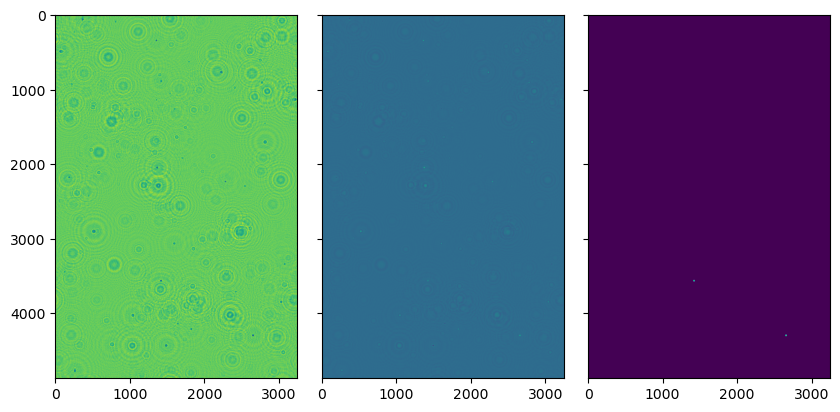

In [315]:
fontsize = 10
single_column_width = 10

figsize = (single_column_width, 8)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize,  
                                   gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, 
                                   sharex=True, sharey=True)

ax1.imshow(z)
ax2.imshow(a)
ax3.imshow(m)

plt.tight_layout()